# Notes

* `d2['file_scores'][k]['paths']` is a matrix of all-pairs segment-to-segment alignments
  * indices are relative to the segment in question
  * same..`['scores']` is the alignment scores: 
  * use `< thresholds['none']` to find the good segment pairs
* generate data from
  * isophonics functions
  * salami functions
  * l2 norm
* samples:
  * features = patches of cqt +- 5 frames on either side
  * positives = drawn from pairs of segments below threshold
  * negatives = "" above the threshold
* model evaluation
  * serra method or laplacian

In [1]:
import numpy as np
import librosa
import cPickle as pickle
import numba
import os
from joblib import Parallel, delayed

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def symstack(X, n_steps=3, delay=1, **kwargs):
    '''Symmetric history stacking.
    
    like librosa.feature.stack_memory, but IN THE FUTURE!!!
    '''
    rpad = n_steps * delay
    Xpad = np.pad(X,
                  [(0, 0), (0, rpad)],
                  **kwargs)
    
    Xstack = librosa.feature.stack_memory(Xpad,
                                          n_steps=2 * n_steps + 1,
                                          delay=delay,
                                          **kwargs)
    
    return Xstack[:, rpad:]

In [49]:
def load_feature_data(file_name, n_steps=5):
    
    fname = '../data/features/{}.pk'.format(file_name)
    
    data = pickle.load(open(fname, 'r'))
    
    return symstack(data['cqgram'].astype(np.float32),
                    n_steps=n_steps,
                    mode='edge'), data['intframes']

In [50]:
@numba.jit
def similarity_paths(X_raw, t_i, t_j, n_samples, max_samples, only_one=True):
    
    X = np.empty((len(t_i), X_raw.shape[0]), dtype=X_raw.dtype)
    
    S = np.zeros((X_raw.shape[1], X_raw.shape[1]))
    
    k = 0
    used_once = np.zeros(X_raw.shape[1], dtype=bool)
    
    for i, j in zip(t_i, t_j):
        if n_samples[i] >= max_samples:
            continue
        
        if only_one and (used_once[i] or used_once[j]):
            continue
            
        S[i, j] = 1
        n_samples[i] += 1
        n_samples[j] += 1
        used_once[i] = True
        used_once[j] = True
        
        #X[k] = np.abs(X_raw[:, i] - X_raw[:, j])
        #k = k + 1
    
    return S

In [51]:
import scipy.spatial

In [72]:
def plot_selfsim(max_samples=4,
                       paths=None,
                       file_name=None,
                       thresholds=None,
                       labels=None,
                       intervals=None,
                       fmeasures=None,
                       scores=None):
    
    # intframes gives the section->cqt frame alignments
    X_raw, intframes = load_feature_data(file_name)
    
    thresh = thresholds['none']
    
    n_segments = len(paths)
    
    n_samples = np.zeros((2, X_raw.shape[1]))
    
    ex_x, ex_y = [], []
    
    S = np.zeros((X_raw.shape[1], X_raw.shape[1]))
    
    for seg_i in range(n_segments):
        off_i = intframes[seg_i, 0]
        
        for seg_j in range(seg_i + 1, len(paths[seg_i])):
            off_j = intframes[seg_j, 0]
            
            if not isinstance(paths[seg_i][seg_j], list):
                continue
                
            if scores[seg_i, seg_j] <= thresh:
                y = 1
            else:
                y = -1
            
            
            # Pull out features from the path
            t_i, t_j = paths[seg_i][seg_j]
            t_i = t_i + off_i
            t_j = t_j + off_j
            S += y * similarity_paths(X_raw, t_i, t_j, n_samples[y], max_samples, only_one=(y>0))
            
    return S + S.T, scipy.spatial.distance.cdist(X_raw.T, X_raw.T)

In [53]:
@numba.jit
def get_feature_paths(X_raw, t_i, t_j, n_samples, max_samples, only_one=True):
    
    X = np.empty((len(t_i), X_raw.shape[0]), dtype=X_raw.dtype)
    
    k = 0
    used_once = np.zeros(X_raw.shape[1], dtype=bool)
    
    for i, j in zip(t_i, t_j):
        if n_samples[i] >= max_samples:
            continue
            
        if only_one and (used_once[i] or used_once[j]):
            continue
            
        n_samples[i] += 1
        n_samples[j] += 1
        
        used_once[i] = True
        used_once[j] = True
        
        X[k] = np.abs(X_raw[:, i] - X_raw[:, j])
        k = k + 1
    
    return X[:k]

In [54]:
def make_training_data(max_samples=4,
                       paths=None,
                       file_name=None,
                       thresholds=None,
                       labels=None,
                       intervals=None,
                       fmeasures=None,
                       scores=None):
    
    # intframes gives the section->cqt frame alignments
    X_raw, intframes = load_feature_data(file_name)
    
    thresh = thresholds['none']
    
    n_segments = len(paths)
    
    n_samples = np.zeros((2, X_raw.shape[1]))
    
    ex_x, ex_y = [], []
    
    for seg_i in range(n_segments):
        off_i = intframes[seg_i, 0]
        
        for seg_j in range(seg_i + 1, len(paths[seg_i])):
            off_j = intframes[seg_j, 0]
            
            if not isinstance(paths[seg_i][seg_j], list):
                continue
                
            if scores[seg_i, seg_j] <= thresh:
                y = 1
            else:
                y = 0
                
            # Pull out features from the path
            t_i, t_j = paths[seg_i][seg_j]
            t_i = t_i + off_i
            t_j = t_j + off_j
            
            X = get_feature_paths(X_raw, t_i, t_j, n_samples[y], max_samples, only_one=y)
            ex_x.append(X)
            ex_y.append(y * np.ones(len(X), dtype=np.int32))
    
    ex_x = np.concatenate(ex_x)
    ex_y = np.concatenate(ex_y)

    return ex_x, ex_y

In [55]:
import os
def process_file(file_scores, max_samples=8):
    
    if file_scores['paths']:
        X, Y = make_training_data(max_samples=max_samples,
                                  **file_scores)
        outfile = '../data/labeled_features/{}_beats.npz'.format(os.path.basename(file_scores['file_name']))
        np.savez(outfile, X=X, Y=Y)

In [69]:
#all_data = pickle.load(open('../data/scores_datasetESALAMI_levelEfunction_distEL2.pk'))
#all_data = pickle.load(open('../data/scores_datasetEIsophonics_levelEfunction_distEL2.pk'))
all_data = pickle.load(open('../data/scores_datasetEIsophonics_levelEfunction_distEL2_beats.pk'))
#all_data = pickle.load(open('../data/scores_datasetESALAMI_levelEfunction_distEL2_beats.pk'))

In [70]:
[(x, y['file_name']) for (x,y) in enumerate(all_data['file_scores'])]

[(0, 'Isophonics_15 Friends Will Be Friends.mp3'),
 (1, 'Isophonics_10_-_Things_We_Said_Today.mp3'),
 (2, 'Isophonics_1-06 Ben (Single Version).mp3'),
 (3, 'Isophonics_04 I Want It All.mp3'),
 (4, 'Isophonics_1-18 Human Nature.mp3'),
 (5, 'Isophonics_06_-_Let_It_Be.mp3'),
 (6, "Isophonics_13_-_I'll_Be_Back.mp3"),
 (7, 'Isophonics_06_-_Ask_Me_Why.mp3'),
 (8, 'Isophonics_CD1_-_13_-_Rocky_Raccoon.mp3'),
 (9, "Isophonics_03_-_Baby's_In_Black.mp3"),
 (10, 'Isophonics_CD1_-_09_-_Martha_My_Dear.mp3'),
 (11, 'Isophonics_11_-_In_My_Life.mp3'),
 (12, 'Isophonics_1-16 Beat It.mp3'),
 (13, 'Isophonics_CD2_-_01_-_Birthday.mp3'),
 (14, 'Isophonics_07_-_Kansas_City-_Hey,_Hey,_Hey,_Hey.mp3'),
 (15, 'Isophonics_18_-_Zuhause.mp3'),
 (16, 'Isophonics_15 No-One But You.mp3'),
 (17, 'Isophonics_15 Seven Seas Of Rhye.mp3'),
 (18, 'Isophonics_01_-_Taxman.mp3'),
 (19, 'Isophonics_08_-_Love_Me_Do.mp3'),
 (20, 'Isophonics_13_-_Not_A_Second_Time.mp3'),
 (21, 'Isophonics_17_-_Her_Majesty.mp3'),
 (22, 'Isophonics_

In [83]:
S_p, S = plot_selfsim(max_samples=16, **all_data['file_scores'][102])

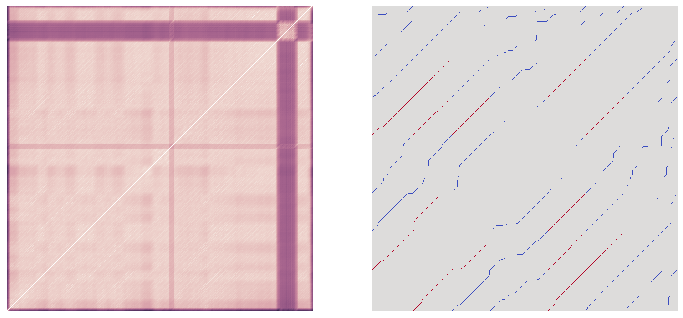

In [84]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
librosa.display.specshow(S, aspect='equal')
plt.subplot(1,2,2)
librosa.display.specshow(S_p, vmin=-1, vmax=1.0, cmap='coolwarm', aspect='equal')

In [71]:
Parallel(n_jobs=4, verbose=20)(delayed(process_file)(data) for data in all_data['file_scores']);

[Parallel(n_jobs=4)]: Done   1 out of 299 | elapsed:    0.8s remaining:  3.8min
[Parallel(n_jobs=4)]: Done  16 out of 299 | elapsed:    1.0s remaining:   17.2s
[Parallel(n_jobs=4)]: Done  31 out of 299 | elapsed:    1.3s remaining:   11.0s
[Parallel(n_jobs=4)]: Done  46 out of 299 | elapsed:    1.6s remaining:    8.9s
[Parallel(n_jobs=4)]: Done  61 out of 299 | elapsed:    1.9s remaining:    7.3s
[Parallel(n_jobs=4)]: Done  76 out of 299 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=4)]: Done  91 out of 299 | elapsed:    2.4s remaining:    5.6s
[Parallel(n_jobs=4)]: Done 106 out of 299 | elapsed:    2.8s remaining:    5.1s
[Parallel(n_jobs=4)]: Done 121 out of 299 | elapsed:    3.2s remaining:    4.7s
[Parallel(n_jobs=4)]: Done 136 out of 299 | elapsed:    3.7s remaining:    4.4s
[Parallel(n_jobs=4)]: Done 151 out of 299 | elapsed:    4.4s remaining:    4.3s
[Parallel(n_jobs=4)]: Done 166 out of 299 | elapsed:    4.7s remaining:    3.8s
[Parallel(n_jobs=4)]: Done 181 out of 29